# Analyse de la qualité des eaux Chinoises


## Objectif 

À rédiger précisément dans le rapport.

Étudier et modéliser la qualité des eaux chinoises afin d'expliquer et de prédire un indice de pollution à partir des caractéristiques géographiques et de la composition chimique des eaux étudiées.

In [2]:
#imports
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#séparer le data set en testset 10% et trainset 90%
csv_path = 'dataset.csv'
df = pd.read_csv(csv_path)
RANDOM_STATE = 42
# séparation aléatoire 90%/10%
train_df, val_df = train_test_split(df, test_size=0.10, random_state=RANDOM_STATE)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f'Total lignes: {len(df)} ; Train: {len(train_df)} ({len(train_df)/len(df):.2%}) ; Validation: {len(val_df)} ({len(val_df)/len(df):.2%})')

Total lignes: 3000 ; Train: 2700 (90.00%) ; Validation: 300 (10.00%)


## 3) Analyse descriptive des variables
Do a descriptive analysis of the variables of the model. Provide a table
 with mean, standard deviation, skewness and kurtosis. Show boxplots
 of the variables, and the correlation matrix.

Table des statistiques descriptives (variables numériques):


,mean,sd,skewness,kurtosis
Unnamed: 0,1506.2933,864.1948,-0.0037,-1.1945
Water_Temperature_C,20.0290,4.9190,0.0161,-0.0055
pH,7.2080,0.5974,0.2001,-0.1219
Dissolved_Oxygen_mg_L,7.9844,1.9768,0.0172,-0.1360
Conductivity_uS_cm,509.0740,104.2109,0.0195,0.1299
Turbidity_NTU,5.0504,5.0559,2.0644,7.2691
Nitrate_mg_L,2.0290,0.5294,0.1031,0.0127
Nitrite_mg_L,0.0204,0.0102,-0.0162,-0.0222
Ammonia_N_mg_L,0.5154,0.2071,0.0431,-0.1113
Total_Phosphorus_mg_L,0.1034,0.0518,-0.0365,-0.0897


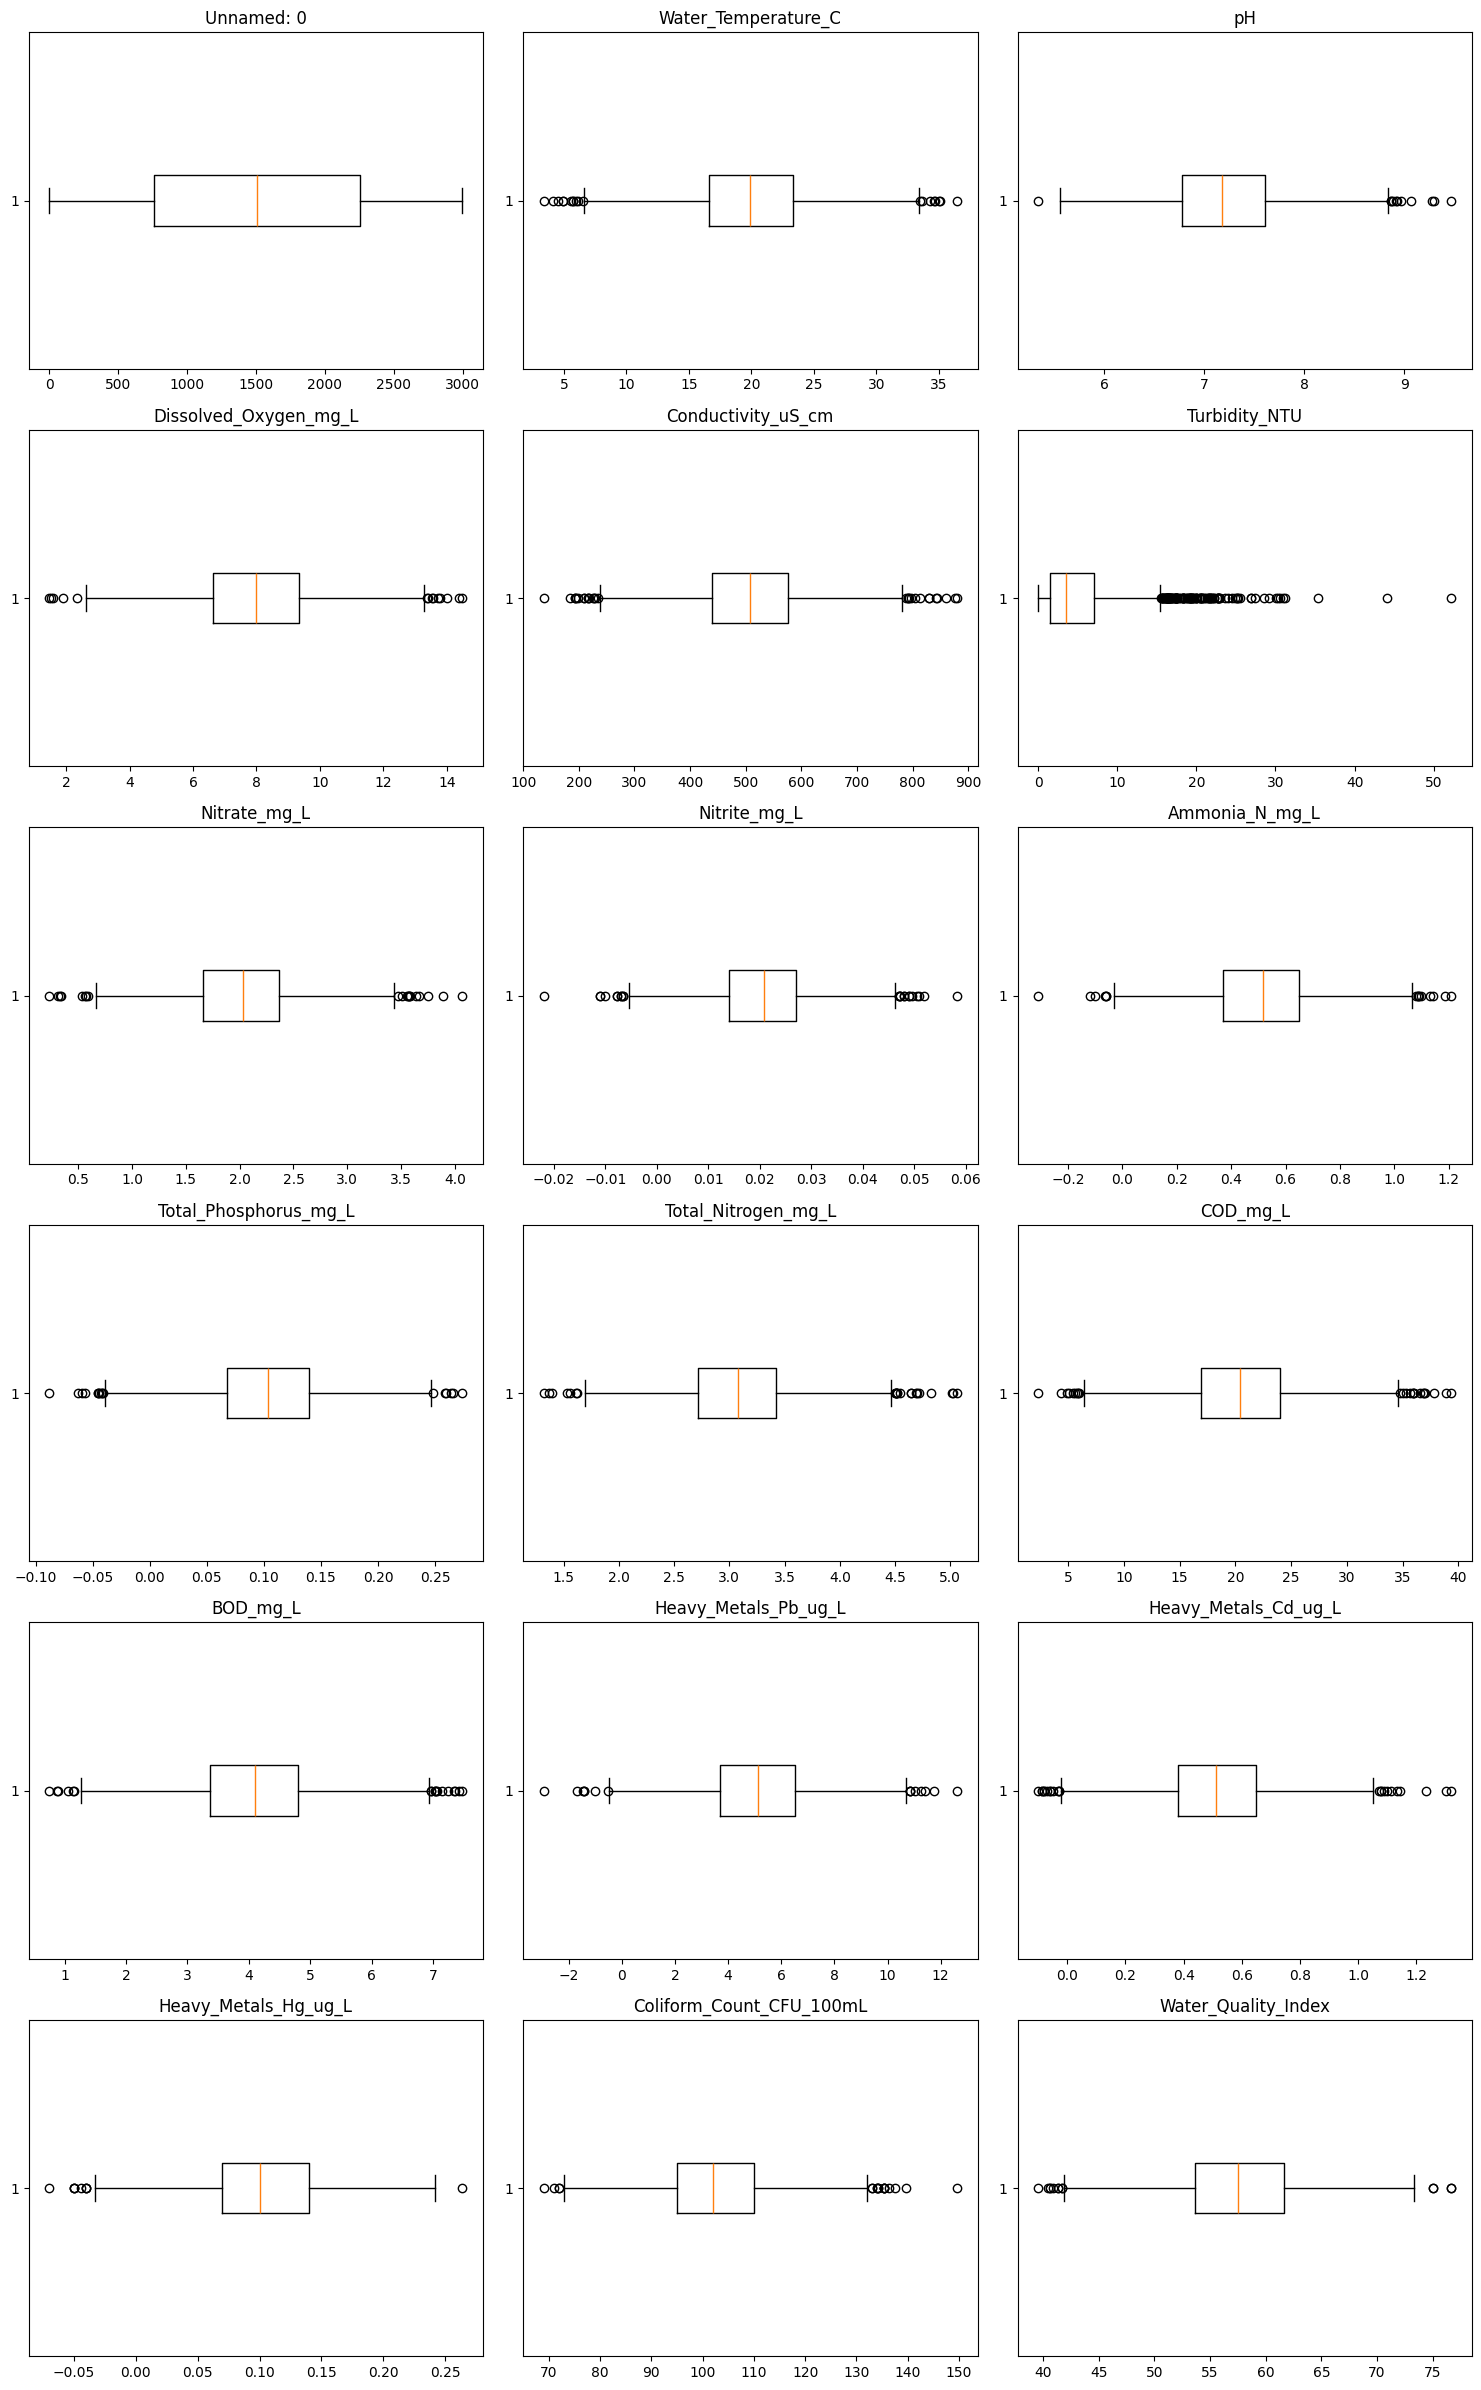

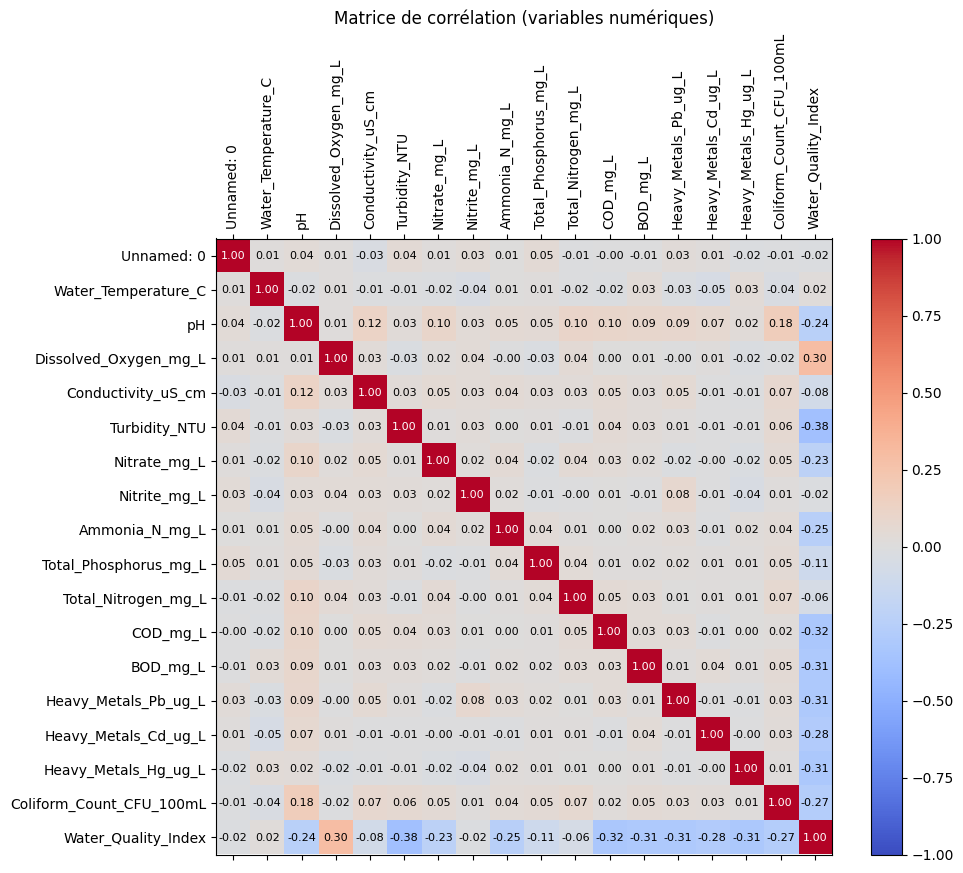

In [4]:
# calcule de la moyenne, ecart-type, skewness et kurtosis + boxplot et correlation matrix
response_var = '<Water_Quality_Index>'

num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

#table
stats_table = pd.DataFrame({
    'mean':train_df[num_cols].mean(),
    'sd': train_df[num_cols].std(),
    'skewness': train_df[num_cols].skew(),
    'kurtosis': train_df[num_cols].kurt()
}).round(4)
print('Table des statistiques descriptives (variables numériques):')
display(stats_table)

#boxplot
cols = num_cols
n = len(cols)
ncols = 3
nrows = (n + ncols - 1) // ncols
plt.figure(figsize=(5 * ncols, 4 * max(1, nrows)))
for i, c in enumerate(cols, 1):
    plt.subplot(nrows, ncols, i)
    plt.boxplot(train_df[c].dropna(), vert=False)
    plt.title(c)
plt.tight_layout()
plt.show()

#correlation matrix
corr = train_df[num_cols].corr()
fig, ax = plt.subplots(figsize=(10,8))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ax.set_xticks(range(len(num_cols)))
ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=90)
ax.set_yticklabels(num_cols)

for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if abs(val)>0.5 else 'black', fontsize=8)
plt.title('Matrice de corrélation (variables numériques)')
plt.show()


## 4) Sélection de modèle et vérification des hypothèses
Select an adequate model for the response variable by considering all
 quantitative and qualitative variables and by using our model selec
tion strategies. Consider also possible interactions of the qualitative
 variables with one or several quantitative variables. Verify the under
lying hypotheses and, if necessary, take remedial actions. For example,
 check for : 
  (a) nonlinearity
 (b) outliers and/or influential observations,
 (c) multicollinearity,
 (d) heteroskedasticty, and
 (e) autocorrelation.

In [5]:
#c'est big ça mere GL
#diagnostics + solutions + choix du modele 
SSEp = 
def R_squared_adj(n,p):
    return 1 - (n-1*)

SyntaxError: invalid syntax (384090406.py, line 3)

### conclusion du point 4

## 5) Tests de sens et interprétation
 Test for significance of the estimated coefficients of the obtained model,
 and interpret their signs. Give a more detailed interpretation of the
 coefficients of the qualitative variables

In [ ]:
#c'est pas fini mnt prouve que le modele est pas guez (tests significativite,interpretation des variables qualitatives,...)

## 6) Test d'une combinaison linéaire à 2 coefficients


In [ ]:
#vas y test

## 7) Test d'un sous-ensemble de coefficients égaux à zéro


In [ ]:
#tout est dit fonce

## 8) Intervalles de prédiction pour les données de validation
Calculate prediction intervals for the validation data. Does the cover
age percentage of these intervals correspond to the nominal level? If
 not, what could be a reason?

In [ ]:
#jsp quoi dire mais c'est presque fini !

### Conclusion du point 8

## 9) Conclusion


## 10) Déclaration d'utilisation d'IA


tkt